# This notebook plots lifecycle composites of MCS environments for multiple trackers

## The MCS environment statistics data is produced by:
- /src/extract_mcs_2d_env.py
- /src/avg_mcs_track_env_space.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

env_varname = 'intqv'

# lifetime_bounds = [2,80]
lifetime_bounds = [2,100]
region = 'tropics'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_DL = f'{rootdir}DL/'
dir_KFyAO = f'{rootdir}KFyAO/'
dir_TIMPS = f'{rootdir}TIMPS/'
dir_ATRACKCS = f'{rootdir}ATRACKCS/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Track files
trackfiles_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_TOOCAN = {key:f'{dir_TOOCAN}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_tobac = {key:f'{dir_tobac}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_TAMS = {key:f'{dir_TAMS}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_simpleTrack = {key:f'{dir_simpleTrack}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_DL = {key:f'{dir_DL}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_KFyAO = {key:f'{dir_KFyAO}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_TIMPS = {key:f'{dir_TIMPS}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
trackfiles_ATRACKCS = {key:f'{dir_ATRACKCS}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

# Environmental files
envfiles_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_MOAAP = {key:f'{dir_MOAAP}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_TOOCAN = {key:f'{dir_TOOCAN}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_tobac = {key:f'{dir_tobac}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_TAMS = {key:f'{dir_TAMS}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_simpleTrack = {key:f'{dir_simpleTrack}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_DL = {key:f'{dir_DL}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_KFyAO = {key:f'{dir_KFyAO}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_TIMPS = {key:f'{dir_TIMPS}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}
envfiles_ATRACKCS = {key:f'{dir_ATRACKCS}mcs_tracks_{PHASE}_{value}_{env_varname}_1d.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in trackfiles_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_tracks_Summer_OBS_intqv_1d.nc: True

In [4]:
for key, value in trackfiles_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/

In [5]:
for key, value in trackfiles_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Su

In [6]:
for key, value in trackfiles_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/

In [7]:
for key, value in trackfiles_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_tracks_S

In [8]:
for key, value in trackfiles_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_tracks_Summer_OBS_intqv_

In [9]:
for key, value in trackfiles_DL.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_DL.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_tracks_Summer_OBSv7_intqv_1d.nc:

In [10]:
for key, value in trackfiles_KFyAO.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_KFyAO.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/

In [11]:
for key, value in trackfiles_TIMPS.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_TIMPS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TIMPS/

In [12]:
for key, value in trackfiles_ATRACKCS.items():
    print(f'{value}: {os.path.isfile(value)}')

for key, value in envfiles_ATRACKCS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_stats_Summer_SCREAMv1.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/ATRACKCS/mcs_tracks_Summer_OBS_intqv_1d.nc: True
/pscratch/sd/f/feng04

## Read data

In [13]:
# Read a sample data
ds_tmp = xr.open_dataset(trackfiles_PyFLEXTRKR['obs'])

# Get global attributes (assume the same for all data)
pixel_radius = ds_tmp.attrs['pixel_radius_km']
time_resolution = ds_tmp.attrs['time_resolution_hour']

# Convert lifetime bounds (hour) to track duration bounds
duration_bounds = (lifetime_bounds / time_resolution).astype(int)
duration_max = max(duration_bounds)

In [14]:
# Specify averaging radius to use from the DataSet (0.5, 1.0, 1.5, 2.5)
radius_deg = 0.5  # [degree]
# Convert radius to diameter & unit from [degree] to [km]
diameter_km = int(radius_deg * 2 * 100)
print(f'Env averaging diameter: {diameter_km} km')

Env averaging diameter: 100 km


In [15]:
# Read all track files and combine them with a new dimension 'source'
dst_pyflex = xr.open_mfdataset(list(trackfiles_PyFLEXTRKR.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_pyflex['source'] = list(name_map.keys())

# Read all env files and combine them
dse_pyflex = xr.open_mfdataset(list(envfiles_PyFLEXTRKR.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_pyflex = dse_pyflex.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_pyflex = xr.combine_by_coords([dst_pyflex, dse_pyflex], combine_attrs='drop_conflicts')
ds_pyflex

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/pytho

<xarray.Dataset>
Dimensions:                  (tracks: 5016, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5012 5013 5014 5015
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1357), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1357), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1357), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1357, 124), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [16]:
# Read all track files and combine them with a new dimension 'source'
dst_moaap = xr.open_mfdataset(list(trackfiles_MOAAP.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_moaap['source'] = list(name_map.keys())

# Read all env files and combine them
dse_moaap = xr.open_mfdataset(list(envfiles_MOAAP.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_moaap = dse_moaap.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_moaap = xr.combine_by_coords([dst_moaap, dse_moaap], combine_attrs='drop_conflicts')
ds_moaap

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/pytho

<xarray.Dataset>
Dimensions:                  (tracks: 5142, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5138 5139 5140 5141
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1435), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1435), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1435), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                MOAAP
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [17]:
# Read all track files and combine them with a new dimension 'source'
dst_toocan = xr.open_mfdataset(list(trackfiles_TOOCAN.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_toocan['source'] = list(name_map.keys())

# Read all env files and combine them
dse_toocan = xr.open_mfdataset(list(envfiles_TOOCAN.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_toocan = dse_toocan.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_toocan = xr.combine_by_coords([dst_toocan, dse_toocan], combine_attrs='drop_conflicts')
ds_toocan

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g

<xarray.Dataset>
Dimensions:                  (tracks: 46001, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 277349 277396 278054
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1435), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1435), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1435), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1435, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                TOOCAN
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [18]:
# Read all track files and combine them with a new dimension 'source'
dst_tobac = xr.open_mfdataset(list(trackfiles_tobac.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_tobac['source'] = list(name_map.keys())

# Read all env files and combine them
dse_tobac = xr.open_mfdataset(list(envfiles_tobac.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_tobac = dse_tobac.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_tobac = xr.combine_by_coords([dst_tobac, dse_tobac], combine_attrs='drop_conflicts')
ds_tobac

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g

<xarray.Dataset>
Dimensions:                  (tracks: 36726, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 2 3 6 ... 126662 126718 126729
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1677), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1677), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1677), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1677, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                tobac
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [19]:
# Read all track files and combine them with a new dimension 'source'
dst_tams = xr.open_mfdataset(list(trackfiles_TAMS.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_tams['source'] = list(name_map.keys())

# Read all env files and combine them
dse_tams = xr.open_mfdataset(list(envfiles_TAMS.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_tams = dse_tams.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_tams = xr.combine_by_coords([dst_tams, dse_tams], combine_attrs='drop_conflicts')
ds_tams

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/pytho

<xarray.Dataset>
Dimensions:                  (tracks: 4575, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4571 4572 4573 4574
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1306), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1306), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1306), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1306, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                TAMS
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [20]:
# Read all track files and combine them with a new dimension 'source'
dst_simtrack = xr.open_mfdataset(list(trackfiles_simpleTrack.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_simtrack['source'] = list(name_map.keys())

# Read all env files and combine them
dse_simtrack = xr.open_mfdataset(list(envfiles_simpleTrack.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_simtrack = dse_simtrack.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_simtrack = xr.combine_by_coords([dst_simtrack, dse_simtrack], combine_attrs='drop_conflicts')
ds_simtrack

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g

<xarray.Dataset>
Dimensions:                  (tracks: 22929, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 442211 442501 444390
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1707), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1707), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1707), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                simpleTrack
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [21]:
# Read all track files and combine them with a new dimension 'source'
dst_dl = xr.open_mfdataset(list(trackfiles_simpleTrack.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_dl['source'] = list(name_map.keys())

# Read all env files and combine them
dse_dl = xr.open_mfdataset(list(envfiles_simpleTrack.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_dl = dse_dl.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_dl = xr.combine_by_coords([dst_dl, dse_dl], combine_attrs='drop_conflicts')
ds_dl

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g

<xarray.Dataset>
Dimensions:                  (tracks: 22929, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 442211 442501 444390
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1707), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1707), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1707), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1707, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                simpleTrack
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [22]:
# Read all track files and combine them with a new dimension 'source'
dst_kfyao = xr.open_mfdataset(list(trackfiles_KFyAO.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_kfyao['source'] = list(name_map.keys())

# Read all env files and combine them
dse_kfyao = xr.open_mfdataset(list(envfiles_KFyAO.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_kfyao = dse_kfyao.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_kfyao = xr.combine_by_coords([dst_kfyao, dse_kfyao], combine_attrs='drop_conflicts')
ds_kfyao

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g

<xarray.Dataset>
Dimensions:                  (tracks: 4691, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4687 4688 4689 4690
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1368), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1368), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1368), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1368, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                KFyAO
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [23]:
# Read all track files and combine them with a new dimension 'source'
dst_timps = xr.open_mfdataset(list(trackfiles_TIMPS.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_timps['source'] = list(name_map.keys())

# Read all env files and combine them
dse_timps = xr.open_mfdataset(list(envfiles_TIMPS.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_timps = dse_timps.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_timps = xr.combine_by_coords([dst_timps, dse_timps], combine_attrs='drop_conflicts')
ds_timps

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/array/core.py:4867: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/g

<xarray.Dataset>
Dimensions:                  (tracks: 38837, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 100000 100002 ... 783100 783146
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 1749), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1749), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 1749), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 1749, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                TIMPS
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

In [24]:
# Read all track files and combine them with a new dimension 'source'
dst_atrackcs = xr.open_mfdataset(list(trackfiles_ATRACKCS.values()), combine='nested', concat_dim='source').isel({'times':slice(0,duration_max), 'nmaxpf':0})
# Assign new coordinate 'source' using name_map dictionary keys
dst_atrackcs['source'] = list(name_map.keys())

# Read all env files and combine them
dse_atrackcs = xr.open_mfdataset(list(envfiles_ATRACKCS.values()), combine='nested', concat_dim='source').sel({'rel_times':slice(-23,duration_max)}).sel(radius=radius_deg)
dse_atrackcs = dse_atrackcs.rename({'rel_times':'times'})

# Combine track and env DataSets
ds_atrackcs = xr.combine_by_coords([dst_atrackcs, dse_atrackcs], combine_attrs='drop_conflicts')
ds_atrackcs

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/global/common/software/m1867/python/py310/lib/pytho

<xarray.Dataset>
Dimensions:                  (tracks: 8737, times: 124, source: 10)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 8733 8734 8735 8736
  * times                    (times) int64 -23 -22 -21 -20 -19 ... 97 98 99 100
  * source                   (source) <U5 'obs' 'obsv7' 'm1' ... 'm6' 'm7' 'm12'
    nmaxpf                   int64 0
    radius                   float64 0.5
Data variables: (12/39)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 3222), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 3222), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 3222), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    ...                       ...
    pf_accumrainheavy        (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
    intqv                    (source, tracks, times) float32 dask.array<chunksize=(1, 3222, 124), meta=np.ndarray>
Attributes: (12/13)
    title:                  Summer OBS MCS statistics file
    tracker:                ATRACKCS
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    ...                     ...
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Title:                  Mean 2D environments for MCS
    Institution:            Pacific Northwest National Laboratoy
    Contact:                zhe.feng@pnnl.gov

## Custom functions to filter tracks

In [25]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.sel(times=0)
    start_lat = ds_in.meanlat.sel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.sel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [26]:
dss_pyflex = find_tracks_start(ds_pyflex, load_data=False)

In [27]:
dss_moaap = find_tracks_start(ds_moaap, load_data=False)

In [28]:
dss_toocan = find_tracks_start(ds_toocan, load_data=False)

In [29]:
dss_tobac = find_tracks_start(ds_tobac, load_data=False)

In [30]:
dss_tams = find_tracks_start(ds_tams, load_data=False)

In [31]:
dss_simtrack = find_tracks_start(ds_simtrack, load_data=False)

In [32]:
dss_dl = find_tracks_start(ds_dl, load_data=False)

In [33]:
dss_kfyao = find_tracks_start(ds_kfyao, load_data=False)

In [34]:
dss_timps = find_tracks_start(ds_timps, load_data=False)

In [35]:
dss_atrackcs = find_tracks_start(ds_atrackcs, load_data=False)

In [36]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 2521
OBSv7: 2532
ARPEGE: 776
IFS: 2418
MPAS: 1200
NICAM: 2776
SAM: 2644
UM: 1603
FV3: 2054
SCREAMv1: 2701


In [37]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 2649
OBSv7: 2761
ARPEGE: 538
IFS: 2754
MPAS: 1393
NICAM: 2154
SAM: 2229
UM: 1871
FV3: 2181
SCREAMv1: 2846


In [38]:
print(f'Number of MCS (TOOCAN)')
for key in dss_toocan['source'].data:
    ntracks = np.count_nonzero(dss_toocan.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TOOCAN)
OBS: 3830
OBSv7: 4141
ARPEGE: 608
IFS: 4758
MPAS: 1276
NICAM: 3745
SAM: 2451
UM: 2190
FV3: 3063
SCREAMv1: 5316


In [39]:
print(f'Number of MCS (tobac)')
for key in dss_tobac['source'].data:
    ntracks = np.count_nonzero(dss_tobac.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (tobac)
OBS: 3071
OBSv7: 3195
ARPEGE: 1037
IFS: 4023
MPAS: 1236
NICAM: 4310
SAM: 3628
UM: 2543
FV3: 3018
SCREAMv1: 4001


In [40]:
print(f'Number of MCS (TAMS)')
for key in dss_tams['source'].data:
    ntracks = np.count_nonzero(dss_tams.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TAMS)
OBS: 2095
OBSv7: 2211
ARPEGE: 889
IFS: 2767
MPAS: 796
NICAM: 2435
SAM: 3402
UM: 1667
FV3: 2383
SCREAMv1: 2839


In [41]:
print(f'Number of MCS (simpleTrack)')
for key in dss_simtrack['source'].data:
    ntracks = np.count_nonzero(dss_simtrack.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (simpleTrack)
OBS: 2405
OBSv7: 2263
ARPEGE: 1029
IFS: 2590
MPAS: 995
NICAM: 2599
SAM: 3065
UM: 1475
FV3: 2257
SCREAMv1: 2628


In [42]:
print(f'Number of MCS (DL)')
for key in dss_dl['source'].data:
    ntracks = np.count_nonzero(dss_dl.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (DL)
OBS: 2405
OBSv7: 2263
ARPEGE: 1029
IFS: 2590
MPAS: 995
NICAM: 2599
SAM: 3065
UM: 1475
FV3: 2257
SCREAMv1: 2628


In [43]:
print(f'Number of MCS (KFyAO)')
for key in dss_kfyao['source'].data:
    ntracks = np.count_nonzero(dss_kfyao.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (KFyAO)
OBS: 2025
OBSv7: 2205
ARPEGE: 810
IFS: 2503
MPAS: 1012
NICAM: 2367
SAM: 2807
UM: 1495
FV3: 2078
SCREAMv1: 2684


In [44]:
print(f'Number of MCS (TIMPS)')
for key in dss_timps['source'].data:
    ntracks = np.count_nonzero(dss_timps.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TIMPS)
OBS: 2678
OBSv7: 2872
ARPEGE: 1012
IFS: 2947
MPAS: 1233
NICAM: 3783
SAM: 3153
UM: 1805
FV3: 2374
SCREAMv1: 3391


In [45]:
print(f'Number of MCS (ATRACKCS)')
for key in dss_atrackcs['source'].data:
    ntracks = np.count_nonzero(dss_atrackcs.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (ATRACKCS)
OBS: 2000
OBSv7: 4353
ARPEGE: 2490
IFS: 5129
MPAS: 1591
NICAM: 4070
SAM: 5193
UM: 3246
FV3: 3980
SCREAMv1: 4536


## Separate land vs ocean MCS

In [46]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex)

In [47]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap)

In [48]:
dss_toocan_l, dss_toocan_o = get_land_ocean_ds(dss_toocan)

In [49]:
dss_tobac_l, dss_tobac_o = get_land_ocean_ds(dss_tobac)

In [50]:
dss_tams_l, dss_tams_o = get_land_ocean_ds(dss_tams)

In [51]:
dss_simtrack_l, dss_simtrack_o = get_land_ocean_ds(dss_simtrack)

In [52]:
dss_dl_l, dss_dl_o = get_land_ocean_ds(dss_dl)

In [53]:
dss_kfyao_l, dss_kfyao_o = get_land_ocean_ds(dss_kfyao)

In [54]:
dss_timps_l, dss_timps_o = get_land_ocean_ds(dss_timps)

In [55]:
dss_atrackcs_l, dss_atrackcs_o = get_land_ocean_ds(dss_atrackcs)

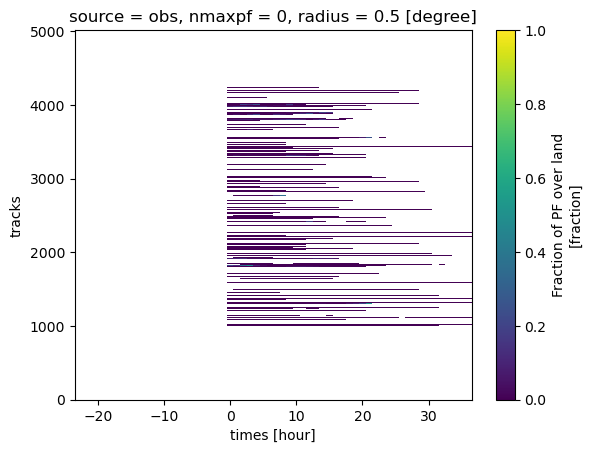

In [56]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

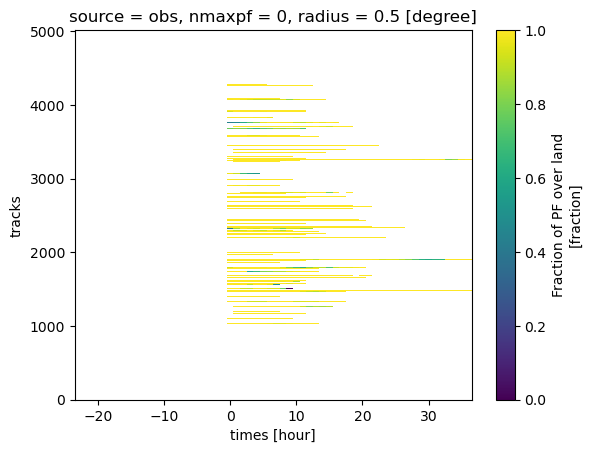

In [57]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

# Composite environment time-series

## Use a simple method to separate possible merge/split tracks
### If max CCS area occur within the first x% of a tracks start time: split; or within last x% of a tracks end time: merge

In [58]:
# Set max area time fraction thresholds (if max area occur between these times, the track is retained)
max_timefrac_thresh = [0.1, 0.9]
# Artificial preCI sample (so preCI times will not be filtered)
ns_preCI = 1000
# Min number of sample after CI to keep the composite values
min_ns = 100
# Quantile values for composite
quantiles = [0.25, 0.5, 0.75]

In [59]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_pyflex_o = dss_pyflex_o.ccs_area.idxmax(dim='times', skipna=True) / dss_pyflex_o.track_duration
maxccs_timefrac_pyflex_l = dss_pyflex_l.ccs_area.idxmax(dim='times', skipna=True) / dss_pyflex_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_pyflex_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_pyflex_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_pyflex_o > min(max_timefrac_thresh)) & (maxccs_timefrac_pyflex_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_pyflex_l > min(max_timefrac_thresh)) & (maxccs_timefrac_pyflex_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_pyflex_o = (dss_pyflex_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_pyflex_l = (dss_pyflex_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_pyflex_o = nsample_pyflex_o.where(nsample_pyflex_o.times > 0, other=ns_preCI)
nsample_pyflex_l = nsample_pyflex_l.where(nsample_pyflex_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_pyflex_o = dss_pyflex_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_pyflex_o > min_ns)).load()
intqv_avg_pyflex_l = dss_pyflex_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_pyflex_l > min_ns)).load()
# intqv_pts_pyflex_o = dss_pyflex_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_pyflex_o > min_ns)).load()
# intqv_pts_pyflex_l = dss_pyflex_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_pyflex_l > min_ns)).load()

(array([ 631., 1102., 1181., 1491., 1760., 1590.,  872.,  802.,    0.]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 9 artists>)

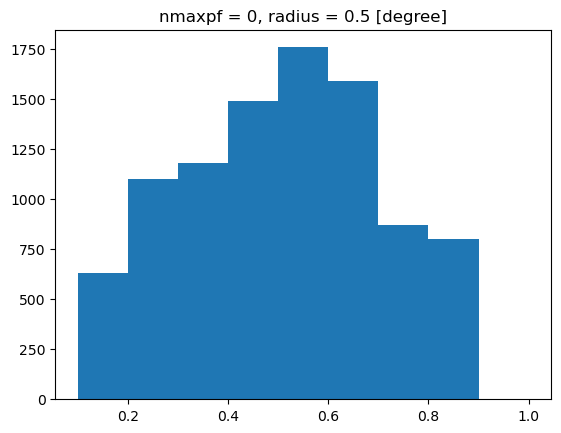

In [60]:
bins = np.arange(0.1, 1.01, 0.1)
maxccs_timefrac_pyflex_o.where(mask_nonmergesplit_o).plot.hist(bins=bins)

In [61]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_moaap_o = dss_moaap_o.ccs_area.idxmax(dim='times', skipna=True) / dss_moaap_o.track_duration
maxccs_timefrac_moaap_l = dss_moaap_l.ccs_area.idxmax(dim='times', skipna=True) / dss_moaap_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_moaap_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_moaap_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_moaap_o > min(max_timefrac_thresh)) & (maxccs_timefrac_moaap_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_moaap_l > min(max_timefrac_thresh)) & (maxccs_timefrac_moaap_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_moaap_o = (dss_moaap_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_moaap_l = (dss_moaap_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_moaap_o = nsample_moaap_o.where(nsample_moaap_o.times > 0, other=ns_preCI)
nsample_moaap_l = nsample_moaap_l.where(nsample_moaap_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_moaap_o = dss_moaap_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_moaap_o > min_ns)).load()
intqv_avg_moaap_l = dss_moaap_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_moaap_l > min_ns)).load()
# intqv_pts_moaap_o = dss_moaap_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_moaap_o > min_ns)).load()
# intqv_pts_moaap_l = dss_moaap_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_moaap_l > min_ns)).load()

In [62]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_toocan_o = dss_toocan_o.ccs_area.idxmax(dim='times', skipna=True) / dss_toocan_o.track_duration
maxccs_timefrac_toocan_l = dss_toocan_l.ccs_area.idxmax(dim='times', skipna=True) / dss_toocan_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_toocan_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_toocan_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_toocan_o > min(max_timefrac_thresh)) & (maxccs_timefrac_toocan_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_toocan_l > min(max_timefrac_thresh)) & (maxccs_timefrac_toocan_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_toocan_o = (dss_toocan_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_toocan_l = (dss_toocan_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_toocan_o = nsample_toocan_o.where(nsample_toocan_o.times > 0, other=ns_preCI)
nsample_toocan_l = nsample_toocan_l.where(nsample_toocan_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_toocan_o = dss_toocan_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_toocan_o > min_ns)).load()
intqv_avg_toocan_l = dss_toocan_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_toocan_l > min_ns)).load()
# intqv_pts_toocan_o = dss_toocan_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_toocan_o > min_ns)).load()
# intqv_pts_toocan_l = dss_toocan_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_toocan_l > min_ns)).load()

In [63]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_tobac_o = dss_tobac_o.ccs_area.idxmax(dim='times', skipna=True) / dss_tobac_o.track_duration
maxccs_timefrac_tobac_l = dss_tobac_l.ccs_area.idxmax(dim='times', skipna=True) / dss_tobac_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_tobac_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_tobac_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_tobac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_tobac_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_tobac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_tobac_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_tobac_o = (dss_tobac_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_tobac_l = (dss_tobac_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_tobac_o = nsample_tobac_o.where(nsample_tobac_o.times > 0, other=ns_preCI)
nsample_tobac_l = nsample_tobac_l.where(nsample_tobac_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_tobac_o = dss_tobac_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_tobac_o > min_ns)).load()
intqv_avg_tobac_l = dss_tobac_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_tobac_l > min_ns)).load()
# intqv_pts_tobac_o = dss_tobac_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_tobac_o > min_ns)).load()
# intqv_pts_tobac_l = dss_tobac_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_tobac_l > min_ns)).load()

In [64]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_tams_o = dss_tams_o.ccs_area.idxmax(dim='times', skipna=True) / dss_tams_o.track_duration
maxccs_timefrac_tams_l = dss_tams_l.ccs_area.idxmax(dim='times', skipna=True) / dss_tams_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_tams_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_tams_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_tams_o > min(max_timefrac_thresh)) & (maxccs_timefrac_tams_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_tams_l > min(max_timefrac_thresh)) & (maxccs_timefrac_tams_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_tams_o = (dss_tams_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_tams_l = (dss_tams_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_tams_o = nsample_tams_o.where(nsample_tams_o.times > 0, other=ns_preCI)
nsample_tams_l = nsample_tams_l.where(nsample_tams_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_tams_o = dss_tams_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_tams_o > min_ns)).load()
intqv_avg_tams_l = dss_tams_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_tams_l > min_ns)).load()
# intqv_pts_tams_o = dss_tams_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_tams_o > min_ns)).load()
# intqv_pts_tams_l = dss_tams_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_tams_l > min_ns)).load()

In [65]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_simtrack_o = dss_simtrack_o.ccs_area.idxmax(dim='times', skipna=True) / dss_simtrack_o.track_duration
maxccs_timefrac_simtrack_l = dss_simtrack_l.ccs_area.idxmax(dim='times', skipna=True) / dss_simtrack_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_simtrack_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_simtrack_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_simtrack_o > min(max_timefrac_thresh)) & (maxccs_timefrac_simtrack_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_simtrack_l > min(max_timefrac_thresh)) & (maxccs_timefrac_simtrack_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_simtrack_o = (dss_simtrack_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_simtrack_l = (dss_simtrack_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_simtrack_o = nsample_simtrack_o.where(nsample_simtrack_o.times > 0, other=ns_preCI)
nsample_simtrack_l = nsample_simtrack_l.where(nsample_simtrack_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_simtrack_o = dss_simtrack_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_simtrack_o > min_ns)).load()
intqv_avg_simtrack_l = dss_simtrack_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_simtrack_l > min_ns)).load()
# intqv_pts_simtrack_o = dss_simtrack_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_simtrack_o > min_ns)).load()
# intqv_pts_simtrack_l = dss_simtrack_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_simtrack_l > min_ns)).load()

In [66]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_dl_o = dss_dl_o.ccs_area.idxmax(dim='times', skipna=True) / dss_dl_o.track_duration
maxccs_timefrac_dl_l = dss_dl_l.ccs_area.idxmax(dim='times', skipna=True) / dss_dl_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_dl_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_dl_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_dl_o > min(max_timefrac_thresh)) & (maxccs_timefrac_dl_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_dl_l > min(max_timefrac_thresh)) & (maxccs_timefrac_dl_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_dl_o = (dss_dl_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_dl_l = (dss_dl_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_dl_o = nsample_dl_o.where(nsample_dl_o.times > 0, other=ns_preCI)
nsample_dl_l = nsample_dl_l.where(nsample_dl_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_dl_o = dss_dl_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_dl_o > min_ns)).load()
intqv_avg_dl_l = dss_dl_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_dl_l > min_ns)).load()
# intqv_pts_dl_o = dss_dl_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_dl_o > min_ns)).load()
# intqv_pts_dl_l = dss_dl_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_dl_l > min_ns)).load()

In [67]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_kfyao_o = dss_kfyao_o.ccs_area.idxmax(dim='times', skipna=True) / dss_kfyao_o.track_duration
maxccs_timefrac_kfyao_l = dss_kfyao_l.ccs_area.idxmax(dim='times', skipna=True) / dss_kfyao_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_kfyao_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_kfyao_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_kfyao_o > min(max_timefrac_thresh)) & (maxccs_timefrac_kfyao_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_kfyao_l > min(max_timefrac_thresh)) & (maxccs_timefrac_kfyao_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_kfyao_o = (dss_kfyao_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_kfyao_l = (dss_kfyao_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_kfyao_o = nsample_kfyao_o.where(nsample_kfyao_o.times > 0, other=ns_preCI)
nsample_kfyao_l = nsample_kfyao_l.where(nsample_kfyao_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_kfyao_o = dss_kfyao_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_kfyao_o > min_ns)).load()
intqv_avg_kfyao_l = dss_kfyao_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_kfyao_l > min_ns)).load()
# intqv_pts_kfyao_o = dss_kfyao_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_kfyao_o > min_ns)).load()
# intqv_pts_kfyao_l = dss_kfyao_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_kfyao_l > min_ns)).load()

In [68]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_timps_o = dss_timps_o.ccs_area.idxmax(dim='times', skipna=True) / dss_timps_o.track_duration
maxccs_timefrac_timps_l = dss_timps_l.ccs_area.idxmax(dim='times', skipna=True) / dss_timps_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_timps_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_timps_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_timps_o > min(max_timefrac_thresh)) & (maxccs_timefrac_timps_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_timps_l > min(max_timefrac_thresh)) & (maxccs_timefrac_timps_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_timps_o = (dss_timps_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_timps_l = (dss_timps_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_timps_o = nsample_timps_o.where(nsample_timps_o.times > 0, other=ns_preCI)
nsample_timps_l = nsample_timps_l.where(nsample_timps_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_timps_o = dss_timps_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_timps_o > min_ns)).load()
intqv_avg_timps_l = dss_timps_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_timps_l > min_ns)).load()
# intqv_pts_timps_o = dss_timps_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_timps_o > min_ns)).load()
# intqv_pts_timps_l = dss_timps_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_timps_l > min_ns)).load()

In [69]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_atrackcs_o = dss_atrackcs_o.ccs_area.idxmax(dim='times', skipna=True) / dss_atrackcs_o.track_duration
maxccs_timefrac_atrackcs_l = dss_atrackcs_l.ccs_area.idxmax(dim='times', skipna=True) / dss_atrackcs_l.track_duration

# # Masks for non-split
# mask_nonsplit_o = maxccs_timefrac_atrackcs_o > min(max_timefrac_thresh)
# mask_nonsplit_l = maxccs_timefrac_atrackcs_l > min(max_timefrac_thresh)
# Masks for non-merge-splot tracks
mask_nonmergesplit_o = (maxccs_timefrac_atrackcs_o > min(max_timefrac_thresh)) & (maxccs_timefrac_atrackcs_o < max(max_timefrac_thresh))
mask_nonmergesplit_l = (maxccs_timefrac_atrackcs_l > min(max_timefrac_thresh)) & (maxccs_timefrac_atrackcs_l < max(max_timefrac_thresh))

# Calculate number of samples when MCS exist
nsample_atrackcs_o = (dss_atrackcs_o.ccs_area.where(mask_nonmergesplit_o) > 0).sum(dim='tracks')
nsample_atrackcs_l = (dss_atrackcs_l.ccs_area.where(mask_nonmergesplit_l) > 0).sum(dim='tracks')
# Set preCI sample to a high value for filtering purpose
nsample_atrackcs_o = nsample_atrackcs_o.where(nsample_atrackcs_o.times > 0, other=ns_preCI)
nsample_atrackcs_l = nsample_atrackcs_l.where(nsample_atrackcs_l.times > 0, other=ns_preCI)

# Composte among tracks, remove times with insufficient samples
intqv_avg_atrackcs_o = dss_atrackcs_o.intqv.where(mask_nonmergesplit_o).mean(dim='tracks').where((nsample_atrackcs_o > min_ns)).load()
intqv_avg_atrackcs_l = dss_atrackcs_l.intqv.where(mask_nonmergesplit_l).mean(dim='tracks').where((nsample_atrackcs_l > min_ns)).load()
# intqv_pts_atrackcs_o = dss_atrackcs_o.intqv.where(mask_nonmergesplit_o).quantile(quantiles, dim='tracks', skipna=True).where((nsample_atrackcs_o > min_ns)).load()
# intqv_pts_atrackcs_l = dss_atrackcs_l.intqv.where(mask_nonmergesplit_l).quantile(quantiles, dim='tracks', skipna=True).where((nsample_atrackcs_l > min_ns)).load()

In [70]:
# xlims = (-24, 60)
# ylims = (40, 68)

# nrows = 8
# fig, axes = plt.subplots(nrows, 2, figsize=(10,20), dpi=100)
# intqv_avg_pyflex_o.plot.line(x='times', linestyle='-', ax=axes[0][0])
# intqv_avg_pyflex_l.plot.line(x='times', linestyle='-', ax=axes[0][1])

# intqv_avg_moaap_o.plot.line(x='times', linestyle='-', ax=axes[1][0])
# intqv_avg_moaap_l.plot.line(x='times', linestyle='-', ax=axes[1][1])

# intqv_avg_toocan_o.plot.line(x='times', linestyle='-', ax=axes[2][0])
# intqv_avg_toocan_l.plot.line(x='times', linestyle='-', ax=axes[2][1])

# intqv_avg_tobac_o.plot.line(x='times', linestyle='-', ax=axes[3][0])
# intqv_avg_tobac_l.plot.line(x='times', linestyle='-', ax=axes[3][1])

# intqv_avg_tams_o.plot.line(x='times', linestyle='-', ax=axes[4][0])
# intqv_avg_tams_l.plot.line(x='times', linestyle='-', ax=axes[4][1])

# intqv_avg_simtrack_o.plot.line(x='times', linestyle='-', ax=axes[5][0])
# intqv_avg_simtrack_l.plot.line(x='times', linestyle='-', ax=axes[5][1])

# intqv_avg_dl_o.plot.line(x='times', linestyle='-', ax=axes[6][0])
# intqv_avg_dl_l.plot.line(x='times', linestyle='-', ax=axes[6][1])

# intqv_avg_kfyao_o.plot.line(x='times', linestyle='-', ax=axes[7][0])
# intqv_avg_kfyao_l.plot.line(x='times', linestyle='-', ax=axes[7][1])

# for row in range(nrows):
#     for col in range(2):
#         axes[row][col].set_xlim(xlims[0], xlims[1])
#         axes[row][col].set_ylim(ylims[0], ylims[1])
# fig.tight_layout()

In [71]:
# Check the histogram of max area time fraction (should peak in the middle ~0.5 of the track)
# maxccs_timefrac_moaap_o.where(maxccs_timefrac_moaap_o > max_timefrac_thresh).sel(source='obs').plot.hist(bins=np.arange(0, 1.01, 0.1))

In [72]:
# _trackid_split = np.where(maxccs_timefrac_pyflex_o.sel(source='obs') <= max_timefrac_thresh[1])[0]
# _trackid_split

In [73]:
# dss_pyflex_o.ccs_area.sel(tracks=_trackid_split[0], source='obs').plot()

# Function to plot time series for multiple trackers

In [74]:
def plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, col_labels=None, wspace=None, hspace=None,
                 shade_dict=None, draw_arrow=False, text_dict=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs': 'k', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    lws = {
        'obs': lw*3, 
        'obsv7': lw*2,
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.1, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Share x-axis for all rows in each column
            if row < nrow - 1:
                # ax.get_xaxis().set_visible(False)
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlabels[col])
            
            # Plot data
            # for key, val in data_arr[row][col].items():
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xtime, idata, lcolors[key], lw=lws[key], label=legends[key])
                # yspan = (ylims[col][1] - ylims[col][0])
                # amp = amp_arr[row][col][key] * amp_scale[col]  # scale the diurnal amplitude
                # # Plot diurnal phase and amplitude
                # ax.scatter(phs_arr[row][col][key], ylims[col][0]+yspan*0.01, s=15, marker='^', facecolor=lcolors[key])
                # ax.axvline(phs_arr[row][col][key], ymax=ylims[col][0]+amp, color=lcolors[key], lw=lws[key])
            ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            # ax.set_xlabel(xlabels[row][col])
            if ylabels is not None: ax.set_ylabel(ylabels[row][col])
            if xticks is not None: ax.set_xticks(xticks)
            if ylims is not None: ax.set_ylim(ylims[col][0], ylims[col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
                # ax.legend(fontsize=legend_fontsize, loc=legend_loc[col], ncol=legend_ncol[col])
            # Fill background color
            if shade_dict:
                xmin, xmax = ax.get_xlim()
                ax.axvspan(xmin, shade_dict['x'], facecolor=shade_dict['color'], alpha=shade_dict['alpha'], transform=ax.get_xaxis_transform())
                # ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                
            # Draw an arrow to show the direction of time increase
            if (draw_arrow) & (row == nrow-1):
                ax.annotate('', xy=(1, -0.35), xytext=(0, -0.35), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

In [75]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(b)', ]
elif PHASE == 'Winter':
    panel_numbers = ['(c)', '(d)', ]
print(panel_numbers)

['(a)', '(b)']


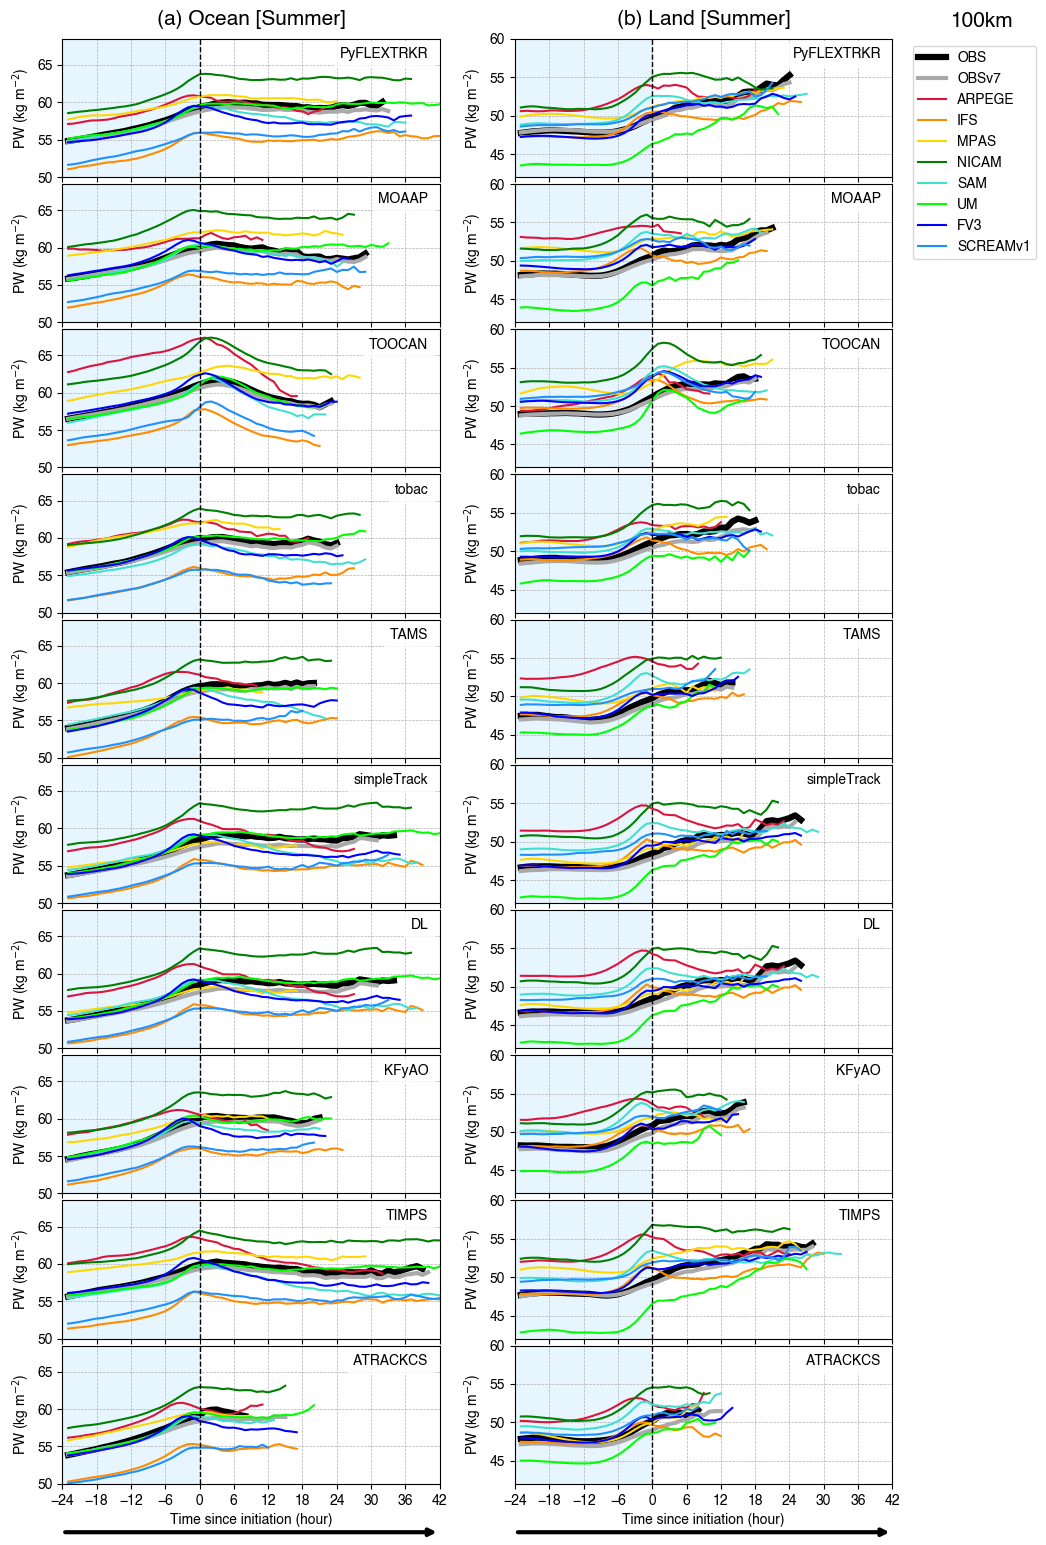

In [76]:
# Data array [row][col]
data_arr = [
    [intqv_avg_pyflex_o, intqv_avg_pyflex_l],
    [intqv_avg_moaap_o, intqv_avg_moaap_l],
    [intqv_avg_toocan_o, intqv_avg_toocan_l],
    [intqv_avg_tobac_o, intqv_avg_tobac_l],
    [intqv_avg_tams_o, intqv_avg_tams_l],
    [intqv_avg_simtrack_o, intqv_avg_simtrack_l],
    [intqv_avg_dl_o, intqv_avg_dl_l],
    [intqv_avg_kfyao_o, intqv_avg_kfyao_l],
    [intqv_avg_timps_o, intqv_avg_timps_l],
    [intqv_avg_atrackcs_o, intqv_avg_atrackcs_l],
]
xtime = intqv_avg_pyflex_o.times
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = [f'{panel_numbers[0]} Ocean [{PHASE}]', f'{panel_numbers[1]} Land [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
    ['TIMPS', 'TIMPS'],
    ['ATRACKCS', 'ATRACKCS'],
]
titles_loc = [0.97, 0.86]
title_ha = 'right'
xlabels = ['Time since initiation (hour)','Time since initiation (hour)']
ylabels = [['PW (kg m$^{-2}$)', 'PW (kg m$^{-2}$)']] * nrow
# xticks = np.arange(-25,40,5)
xticks = np.arange(-24, 42.1, 6)
xlims = [(-24,42),(-24,42)]
if (PHASE == 'Summer'): ylims = [(50,68.5),(42,60)]
if (PHASE == 'Winter'): ylims = [(50,64.5),(42,56)]
# ylims = [(50,64.5),(42,56)]
legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.4, 1)
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
# figsize = [10,16]
figsize = [10,17]
wspace = 0.20
hspace = 0.05
text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
shade_dict = {'x':0, 'color':'lightskyblue', 'alpha':0.2}
# figname = f'{figdir}mcs_pwv_composite_timeseries_ocean_land_all_{diameter_km:.0f}km.png'
figname = f'{figdir}mcs_pwv_composite_timeseries_ocean_land_all_{diameter_km:.0f}km.pdf'

fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_dict=shade_dict, draw_arrow=True, text_dict=text_dict, figname=figname, figsize=figsize)

In [77]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/mcs_pwv_composite_timeseries_ocean_land_all_100km.pdf'

## Mask MCS variables for possible split/merge tracks

In [78]:
# Define preMCS time for sampling the environment
time_env = -1
dss_pyflex_o.times

<xarray.DataArray 'times' (times: 124)>
array([-23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
        -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100])
Coordinates:
  * times    (times) int64 -23 -22 -21 -20 -19 -18 -17 ... 94 95 96 97 98 99 100
    nmaxpf   int64 0
    radius   float64 0.5
Attributes:
    description:  Relative times for MCS lifecycle
    units:        hour

In [79]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_pyflex_o > min(max_timefrac_thresh)) & (maxccs_timefrac_pyflex_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_pyflex_l > min(max_timefrac_thresh)) & (maxccs_timefrac_pyflex_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_pyflex_o = dss_pyflex_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_pyflex_l = dss_pyflex_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_pyflex_o = dss_pyflex_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_pyflex_l = dss_pyflex_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_pyflex_o = dss_pyflex_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_pyflex_l = dss_pyflex_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_pyflex_o = dss_pyflex_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_pyflex_l = dss_pyflex_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_pyflex_o = dss_pyflex_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_pyflex_l = dss_pyflex_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [80]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_moaap_o > min(max_timefrac_thresh)) & (maxccs_timefrac_moaap_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_moaap_l > min(max_timefrac_thresh)) & (maxccs_timefrac_moaap_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_moaap_o = dss_moaap_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_moaap_l = dss_moaap_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_moaap_o = dss_moaap_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_moaap_l = dss_moaap_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_moaap_o = dss_moaap_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_moaap_l = dss_moaap_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_moaap_o = dss_moaap_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_moaap_l = dss_moaap_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_moaap_o = dss_moaap_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_moaap_l = dss_moaap_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [81]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_toocan_o > min(max_timefrac_thresh)) & (maxccs_timefrac_toocan_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_toocan_l > min(max_timefrac_thresh)) & (maxccs_timefrac_toocan_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_toocan_o = dss_toocan_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_toocan_l = dss_toocan_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_toocan_o = dss_toocan_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_toocan_l = dss_toocan_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_toocan_o = dss_toocan_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_toocan_l = dss_toocan_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_toocan_o = dss_toocan_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_toocan_l = dss_toocan_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_toocan_o = dss_toocan_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_toocan_l = dss_toocan_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [82]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_tobac_o > min(max_timefrac_thresh)) & (maxccs_timefrac_tobac_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_tobac_l > min(max_timefrac_thresh)) & (maxccs_timefrac_tobac_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_tobac_o = dss_tobac_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_tobac_l = dss_tobac_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_tobac_o = dss_tobac_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_tobac_l = dss_tobac_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_tobac_o = dss_tobac_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_tobac_l = dss_tobac_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_tobac_o = dss_tobac_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_tobac_l = dss_tobac_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_tobac_o = dss_tobac_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_tobac_l = dss_tobac_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [83]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_tams_o > min(max_timefrac_thresh)) & (maxccs_timefrac_tams_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_tams_l > min(max_timefrac_thresh)) & (maxccs_timefrac_tams_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_tams_o = dss_tams_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_tams_l = dss_tams_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_tams_o = dss_tams_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_tams_l = dss_tams_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_tams_o = dss_tams_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_tams_l = dss_tams_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_tams_o = dss_tams_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_tams_l = dss_tams_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_tams_o = dss_tams_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_tams_l = dss_tams_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [84]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_simtrack_o > min(max_timefrac_thresh)) & (maxccs_timefrac_simtrack_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_simtrack_l > min(max_timefrac_thresh)) & (maxccs_timefrac_simtrack_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_simtrack_o = dss_simtrack_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_simtrack_l = dss_simtrack_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_simtrack_o = dss_simtrack_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_simtrack_l = dss_simtrack_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_simtrack_o = dss_simtrack_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_simtrack_l = dss_simtrack_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_simtrack_o = dss_simtrack_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_simtrack_l = dss_simtrack_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_simtrack_o = dss_simtrack_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_simtrack_l = dss_simtrack_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [85]:
# # Masks for non-merge-splot tracks
# mask_nonmergesplit_o = (maxccs_timefrac_dl_o > min(max_timefrac_thresh)) & (maxccs_timefrac_dl_o < max(max_timefrac_thresh))
# mask_nonmergesplit_l = (maxccs_timefrac_dl_l > min(max_timefrac_thresh)) & (maxccs_timefrac_dl_l < max(max_timefrac_thresh))

# # Get preMCS environmental variable
# intqv_preMCS_dl_o = dss_dl_o.intqv.sel(times=time_env).where(mask_nonmergesplit_o)
# intqv_preMCS_dl_l = dss_dl_l.intqv.sel(times=time_env).where(mask_nonmergesplit_l)
# # MCS lifetime total rain volume [kg]
# pfvolrain_dl_o = dss_dl_o.total_rain.where(mask_nonmergesplit_o).sum(dim='times') * pixel_radius**2
# pfvolrain_dl_l = dss_dl_l.total_rain.where(mask_nonmergesplit_l).sum(dim='times') * pixel_radius**2
# # MCS lifetime max PF area
# pfmaxarea_dl_o = dss_dl_o.pf_area.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxarea_dl_l = dss_dl_l.pf_area.where(mask_nonmergesplit_l).max(dim='times')
# # MCS lifetime max PF rain rate
# pfmaxrr_dl_o = dss_dl_o.pf_rainrate.where(mask_nonmergesplit_o).max(dim='times')
# pfmaxrr_dl_l = dss_dl_l.pf_rainrate.where(mask_nonmergesplit_l).max(dim='times')
# pfmeanrr_dl_o = dss_dl_o.pf_rainrate.where(mask_nonmergesplit_o).mean(dim='times')
# pfmeanrr_dl_l = dss_dl_l.pf_rainrate.where(mask_nonmergesplit_l).mean(dim='times')

In [86]:
# lcolors = {
#     'obs':'k', 
#     'obsv7': 'darkgray',
#     'm1': 'crimson',
#     'm2': 'darkorange', 
#     'm3': 'gold',
#     'm4': 'green',
#     'm5': 'turquoise',
#     'm6': 'lime',
#     'm7': 'blue',
#     'm8': 'deepskyblue',
#     'm9': 'purple',
#     'm10': 'violet',
#     'm11': 'deeppink',
#     'm12': 'dodgerblue',
# }

In [87]:
# bins = np.arange(25, 81, 2)

# fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
# ax1 = axes[0]
# ax2 = axes[1]
# for source in intqv_preMCS_pyflex_o['source'].data:
#     # print(name_map[source])
#     ax1.hist(intqv_preMCS_pyflex_o.sel(source=source), bins=bins, histtype='step', label=f'{name_map[source]}', color=lcolors[source], density=True)
#     ax2.hist(intqv_preMCS_pyflex_l.sel(source=source), bins=bins, histtype='step', label=f'{name_map[source]}', color=lcolors[source], density=True)
# ax1.legend()
# ax1.set_title('Ocean')
# ax2.set_title('Land')

## Function to convert DataArray to Pandas Dataframe
### Dataframe can be used with Seaborn for easier visualization

In [88]:
def dataarray_to_dataframe(da, row_names=None, column_names=None):
    """
    Convert Xarray DataArray to Pandas DataFrame
    """
    # Convert to DataFrame
    df = pd.DataFrame(da.data)
    # Assign 'source' as column names
    if row_names:
        df.index = row_names
    if column_names:
        df.columns = column_names
        # df.columns = list(da['source'].data)
    return df

In [89]:
# df_intqv_preMCS_pyflex_o = dataarray_to_dataframe(intqv_preMCS_pyflex_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_pyflex_l = dataarray_to_dataframe(intqv_preMCS_pyflex_l.transpose(), column_names=name_map.values())

In [90]:
# df_intqv_preMCS_moaap_o = dataarray_to_dataframe(intqv_preMCS_moaap_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_moaap_l = dataarray_to_dataframe(intqv_preMCS_moaap_l.transpose(), column_names=name_map.values())

In [91]:
# df_intqv_preMCS_toocan_o = dataarray_to_dataframe(intqv_preMCS_toocan_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_toocan_l = dataarray_to_dataframe(intqv_preMCS_toocan_l.transpose(), column_names=name_map.values())

In [92]:
# df_intqv_preMCS_tobac_o = dataarray_to_dataframe(intqv_preMCS_tobac_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_tobac_l = dataarray_to_dataframe(intqv_preMCS_tobac_l.transpose(), column_names=name_map.values())

In [93]:
# df_intqv_preMCS_tams_o = dataarray_to_dataframe(intqv_preMCS_tams_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_tams_l = dataarray_to_dataframe(intqv_preMCS_tams_l.transpose(), column_names=name_map.values())

In [94]:
# df_intqv_preMCS_simtrack_o = dataarray_to_dataframe(intqv_preMCS_simtrack_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_simtrack_l = dataarray_to_dataframe(intqv_preMCS_simtrack_l.transpose(), column_names=name_map.values())

In [95]:
# df_intqv_preMCS_dl_o = dataarray_to_dataframe(intqv_preMCS_dl_o.transpose(), column_names=name_map.values())
# df_intqv_preMCS_dl_l = dataarray_to_dataframe(intqv_preMCS_dl_l.transpose(), column_names=name_map.values())

## Function to make box plots on multiple panels

In [96]:
def boxplot_mxn(nrow, ncol, data_arr, titles, xlabels, legends, figname,  
                col_labels=None, fontsize=fontsize, wspace=None, hspace=None, label_row=None, text_dict=None,
                legend_fontsize=11, legend_loc='best', legend_ncol=None, figsize=[10,10]):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    # fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)
    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)

    lcolors = {
        'obs': 'gray', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5    
    meanprops = {"marker": "o", "markerfacecolor": "r", "markeredgecolor": "k"}
    medianprops = {'linewidth': 3}
    barwidth = 0.5
    pcolors = list(lcolors.values())[:data_arr[0][0].shape[1]]
    notch = False

    for col in range(0, ncol): 
        for row in range(0, nrow):
            # ax = axes[row][col]
            ax = plt.subplot(gs[row,col], sharex=ax if row > 0 else None)
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.1, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)
            
            # Label x-axis for the last row
            if row == nrow-1:
                ax.set_xlabel(xlabels[row][col])
            else:
                ax.tick_params(axis='x', labelbottom=False)
                
            sns.boxplot(data=data_arr[row][col], orient='h', ax=ax, palette=pcolors, showfliers=False, showmeans=True, 
                        width=barwidth, meanprops=meanprops, medianprops=medianprops, notch=notch)
            ax.grid(axis='x', ls='--')
            # ax.set_title(titles[row][col], loc='left')
            # if row == nrow-1: ax.set_xlabel(xlabels[row][col])
            # ax.set_xticks(xticks[col])
            # ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_ylim(ylims[row][0], ylims[row][1])
            # if panel_colors is not None:
            #     ax.set_facecolor(panel_colors)
            # Label yaxis, legend
            if (col == 0):
                ax.text(-0.3, 0.5, label_row[row], va='center', ha='center', rotation=90, weight='bold', transform=ax.transAxes)

    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])
        
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [97]:
# col_labels = ['Ocean', 'Land']
# data_arr = [
#     [df_intqv_preMCS_pyflex_o, df_intqv_preMCS_pyflex_l,],
#     [df_intqv_preMCS_moaap_o, df_intqv_preMCS_moaap_l,],
#     [df_intqv_preMCS_toocan_o, df_intqv_preMCS_toocan_l,],
#     [df_intqv_preMCS_tobac_o, df_intqv_preMCS_tobac_l,],
#     [df_intqv_preMCS_tams_o, df_intqv_preMCS_tams_l,],
#     [df_intqv_preMCS_simtrack_o, df_intqv_preMCS_simtrack_l,],
#     [df_intqv_preMCS_dl_o, df_intqv_preMCS_dl_l,],
# ]
# nrow = len(data_arr)
# label_row = ['PyFLEXTRKR','MOAAP','TOOCAN','tobac','TAMS','simpleTrack','DL']
# titles = [
#     ['PyFLEXTRKR', 'PyFLEXTRKR',],
#     ['MOAAP', 'MOAAP',],
#     ['TOOCAN', 'TOOCAN',],
#     ['tobac', 'tobac',],
#     ['TAMS', 'TAMS'],
#     ['simpleTrack', 'simpleTrack'],
#     ['DL', 'DL'],
# ]
# xlabels = [['PW (kg m$^{-2}$)','PW (kg m$^{-2}$)']]*nrow
# legend_ncol = 1
# fontsize = 12
# wspace = 0.25
# hspace = 0.05
# figsize = [10,14]
# text_dict = {'text': f'({diameter_km:.0f}km)', 'x': 0.88, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1}
# figname = f'{figdir}boxplot_preMCS_pwv_ocean_land_{diameter_km:.0f}km.png'
# fig = boxplot_mxn(nrow, 2, data_arr, titles, xlabels, legends, figname,
#                   col_labels=col_labels, fontsize=fontsize, wspace=wspace, hspace=hspace, label_row=label_row,
#                   text_dict=text_dict, legend_fontsize=8, legend_loc='best', legend_ncol=legend_ncol, figsize=figsize)

In [98]:
# # Define the desired number of bins
# num_bins = 5

# # Get all valid values of intqv from all sources
# tmp = intqv_preMCS_pyflex_o.values.flatten()
# tmp = tmp[~np.isnan(tmp)]
# # Compute bin edges to have roughly equal sample size in each bin
# intqv_bins = np.percentile(tmp, np.linspace(0, 100, num_bins + 1))
# intqv_bins_c = intqv_bins[:-1] + (intqv_bins[1:] - intqv_bins[:-1])/2
# print(intqv_bins)
# print(intqv_bins_c)

In [99]:
# pfvolrain_pyflex_o.sel(source='obs').groupby_bins(intqv_preMCS_pyflex_o.sel(source='obs'), bins=intqv_bins).mean().plot(color=lcolors['obs'], lw=4)
# pfvolrain_pyflex_o.sel(source='m1').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m1'), bins=intqv_bins).mean().plot(color=lcolors['m1'])
# pfvolrain_pyflex_o.sel(source='m2').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m2'), bins=intqv_bins).mean().plot(color=lcolors['m2'])
# pfvolrain_pyflex_o.sel(source='m3').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m3'), bins=intqv_bins).mean().plot(color=lcolors['m3'])
# pfvolrain_pyflex_o.sel(source='m4').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m4'), bins=intqv_bins).mean().plot(color=lcolors['m4'])
# pfvolrain_pyflex_o.sel(source='m5').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m5'), bins=intqv_bins).mean().plot(color=lcolors['m5'])
# pfvolrain_pyflex_o.sel(source='m6').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m6'), bins=intqv_bins).mean().plot(color=lcolors['m6'])
# pfvolrain_pyflex_o.sel(source='m7').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m7'), bins=intqv_bins).mean().plot(color=lcolors['m7'])

In [100]:
# pfmaxarea_pyflex_o.sel(source='obs').groupby_bins(intqv_preMCS_pyflex_o.sel(source='obs'), bins=intqv_bins).mean().plot(color=lcolors['obs'], lw=4)
# pfmaxarea_pyflex_o.sel(source='m1').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m1'), bins=intqv_bins).mean().plot(color=lcolors['m1'])
# pfmaxarea_pyflex_o.sel(source='m2').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m2'), bins=intqv_bins).mean().plot(color=lcolors['m2'])
# pfmaxarea_pyflex_o.sel(source='m3').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m3'), bins=intqv_bins).mean().plot(color=lcolors['m3'])
# pfmaxarea_pyflex_o.sel(source='m4').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m4'), bins=intqv_bins).mean().plot(color=lcolors['m4'])
# pfmaxarea_pyflex_o.sel(source='m5').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m5'), bins=intqv_bins).mean().plot(color=lcolors['m5'])
# pfmaxarea_pyflex_o.sel(source='m6').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m6'), bins=intqv_bins).mean().plot(color=lcolors['m6'])
# pfmaxarea_pyflex_o.sel(source='m7').groupby_bins(intqv_preMCS_pyflex_o.sel(source='m7'), bins=intqv_bins).mean().plot(color=lcolors['m7'])

In [101]:
# pfvolrain_pyflex_l.sel(source='obs').groupby_bins(intqv_preMCS_pyflex_l.sel(source='obs'), bins=intqv_bins).mean().plot(color=lcolors['obs'], lw=4)
# pfvolrain_pyflex_l.sel(source='m1').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m1'), bins=intqv_bins).mean().plot(color=lcolors['m1'])
# pfvolrain_pyflex_l.sel(source='m2').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m2'), bins=intqv_bins).mean().plot(color=lcolors['m2'])
# pfvolrain_pyflex_l.sel(source='m3').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m3'), bins=intqv_bins).mean().plot(color=lcolors['m3'])
# pfvolrain_pyflex_l.sel(source='m4').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m4'), bins=intqv_bins).mean().plot(color=lcolors['m4'])
# pfvolrain_pyflex_l.sel(source='m5').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m5'), bins=intqv_bins).mean().plot(color=lcolors['m5'])
# pfvolrain_pyflex_l.sel(source='m6').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m6'), bins=intqv_bins).mean().plot(color=lcolors['m6'])
# pfvolrain_pyflex_l.sel(source='m7').groupby_bins(intqv_preMCS_pyflex_l.sel(source='m7'), bins=intqv_bins).mean().plot(color=lcolors['m7'])

## Count number of samples for each PWV bin for each source

In [102]:
# nsource = len(name_map)
# nbins = len(intqv_bins)-1
# ns_pyflex_o = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_pyflex_l = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_moaap_o = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_moaap_l = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_toocan_o = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_toocan_l = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_tobac_o = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_tobac_l = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_tams_o = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_tams_l = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_simtrack_o = np.full((nsource, nbins), np.NaN, dtype=float)
# ns_simtrack_l = np.full((nsource, nbins), np.NaN, dtype=float)

# for ii, key in enumerate(name_map):
#     print(ii, key)
#     ns_pyflex_o[ii,:] = pfvolrain_pyflex_o.sel(source=key).groupby_bins(intqv_preMCS_pyflex_o.sel(source=key), bins=intqv_bins).count().values
#     ns_pyflex_l[ii,:] = pfvolrain_pyflex_l.sel(source=key).groupby_bins(intqv_preMCS_pyflex_l.sel(source=key), bins=intqv_bins).count().values
#     ns_moaap_o[ii,:] = pfvolrain_moaap_o.sel(source=key).groupby_bins(intqv_preMCS_moaap_o.sel(source=key), bins=intqv_bins).count().values
#     ns_moaap_l[ii,:] = pfvolrain_moaap_l.sel(source=key).groupby_bins(intqv_preMCS_moaap_l.sel(source=key), bins=intqv_bins).count().values
#     ns_toocan_o[ii,:] = pfvolrain_toocan_o.sel(source=key).groupby_bins(intqv_preMCS_toocan_o.sel(source=key), bins=intqv_bins).count().values
#     ns_toocan_l[ii,:] = pfvolrain_toocan_l.sel(source=key).groupby_bins(intqv_preMCS_toocan_l.sel(source=key), bins=intqv_bins).count().values
#     ns_tobac_o[ii,:] = pfvolrain_tobac_o.sel(source=key).groupby_bins(intqv_preMCS_tobac_o.sel(source=key), bins=intqv_bins).count().values
#     ns_tobac_l[ii,:] = pfvolrain_tobac_l.sel(source=key).groupby_bins(intqv_preMCS_tobac_l.sel(source=key), bins=intqv_bins).count().values
#     ns_tams_o[ii,:] = pfvolrain_tams_o.sel(source=key).groupby_bins(intqv_preMCS_tams_o.sel(source=key), bins=intqv_bins).count().values
#     ns_tams_l[ii,:] = pfvolrain_tams_l.sel(source=key).groupby_bins(intqv_preMCS_tams_l.sel(source=key), bins=intqv_bins).count().values
#     ns_simtrack_o[ii,:] = pfvolrain_simtrack_o.sel(source=key).groupby_bins(intqv_preMCS_simtrack_o.sel(source=key), bins=intqv_bins).count().values
#     ns_simtrack_l[ii,:] = pfvolrain_simtrack_l.sel(source=key).groupby_bins(intqv_preMCS_simtrack_l.sel(source=key), bins=intqv_bins).count().values
    
# # Convert to DataArray
# ns_pyflex_o = xr.DataArray(ns_pyflex_o, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_pyflex_l = xr.DataArray(ns_pyflex_l, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_moaap_o = xr.DataArray(ns_moaap_o, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_moaap_l = xr.DataArray(ns_moaap_l, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_toocan_o = xr.DataArray(ns_toocan_o, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_toocan_l = xr.DataArray(ns_toocan_l, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_tobac_o = xr.DataArray(ns_tobac_o, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_tobac_l = xr.DataArray(ns_tobac_l, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_tams_o = xr.DataArray(ns_tams_o, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_tams_l = xr.DataArray(ns_tams_l, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_simtrack_o = xr.DataArray(ns_simtrack_o, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# ns_simtrack_l = xr.DataArray(ns_simtrack_l, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

## Calculate mean MCS property groupby PWV for each source

In [103]:
# nsource = len(name_map)
# nbins = len(intqv_bins)-1
# pfvolrain_avg_pyflex_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_pyflex_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_moaap_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_moaap_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_toocan_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_toocan_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_tobac_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_tobac_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_tams_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_tams_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_simtrack_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfvolrain_avg_simtrack_l = np.full((nsource, nbins), np.NaN, dtype=float)

# for ii, key in enumerate(name_map):
#     print(ii, key)
#     pfvolrain_avg_pyflex_o[ii,:] = pfvolrain_pyflex_o.sel(source=key).groupby_bins(intqv_preMCS_pyflex_o.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_pyflex_l[ii,:] = pfvolrain_pyflex_l.sel(source=key).groupby_bins(intqv_preMCS_pyflex_l.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_moaap_o[ii,:] = pfvolrain_moaap_o.sel(source=key).groupby_bins(intqv_preMCS_moaap_o.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_moaap_l[ii,:] = pfvolrain_moaap_l.sel(source=key).groupby_bins(intqv_preMCS_moaap_l.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_toocan_o[ii,:] = pfvolrain_toocan_o.sel(source=key).groupby_bins(intqv_preMCS_toocan_o.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_toocan_l[ii,:] = pfvolrain_toocan_l.sel(source=key).groupby_bins(intqv_preMCS_toocan_l.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_tobac_o[ii,:] = pfvolrain_tobac_o.sel(source=key).groupby_bins(intqv_preMCS_tobac_o.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_tobac_l[ii,:] = pfvolrain_tobac_l.sel(source=key).groupby_bins(intqv_preMCS_tobac_l.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_tams_o[ii,:] = pfvolrain_tams_o.sel(source=key).groupby_bins(intqv_preMCS_tams_o.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_tams_l[ii,:] = pfvolrain_tams_l.sel(source=key).groupby_bins(intqv_preMCS_tams_l.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_simtrack_o[ii,:] = pfvolrain_simtrack_o.sel(source=key).groupby_bins(intqv_preMCS_simtrack_o.sel(source=key), bins=intqv_bins).mean().values
#     pfvolrain_avg_simtrack_l[ii,:] = pfvolrain_simtrack_l.sel(source=key).groupby_bins(intqv_preMCS_simtrack_l.sel(source=key), bins=intqv_bins).mean().values

# # Convert to DataArray
# pfvolrain_avg_pyflex_o = xr.DataArray(pfvolrain_avg_pyflex_o, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_pyflex_l = xr.DataArray(pfvolrain_avg_pyflex_l, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_moaap_o = xr.DataArray(pfvolrain_avg_moaap_o, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_moaap_l = xr.DataArray(pfvolrain_avg_moaap_l, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_toocan_o = xr.DataArray(pfvolrain_avg_toocan_o, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_toocan_l = xr.DataArray(pfvolrain_avg_toocan_l, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_tobac_o = xr.DataArray(pfvolrain_avg_tobac_o, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_tobac_l = xr.DataArray(pfvolrain_avg_tobac_l, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_tams_o = xr.DataArray(pfvolrain_avg_tams_o, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_tams_l = xr.DataArray(pfvolrain_avg_tams_l, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_simtrack_o = xr.DataArray(pfvolrain_avg_simtrack_o, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfvolrain_avg_simtrack_l = xr.DataArray(pfvolrain_avg_simtrack_l, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

In [104]:
# nsource = len(name_map)
# nbins = len(intqv_bins)-1
# pfmaxarea_avg_pyflex_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_pyflex_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_moaap_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_moaap_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_toocan_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_toocan_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_tobac_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_tobac_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_tams_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_tams_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_simtrack_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxarea_avg_simtrack_l = np.full((nsource, nbins), np.NaN, dtype=float)

# for ii, key in enumerate(name_map):
#     print(ii, key)
#     pfmaxarea_avg_pyflex_o[ii,:] = pfmaxarea_pyflex_o.sel(source=key).groupby_bins(intqv_preMCS_pyflex_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_pyflex_l[ii,:] = pfmaxarea_pyflex_l.sel(source=key).groupby_bins(intqv_preMCS_pyflex_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_moaap_o[ii,:] = pfmaxarea_moaap_o.sel(source=key).groupby_bins(intqv_preMCS_moaap_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_moaap_l[ii,:] = pfmaxarea_moaap_l.sel(source=key).groupby_bins(intqv_preMCS_moaap_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_toocan_o[ii,:] = pfmaxarea_toocan_o.sel(source=key).groupby_bins(intqv_preMCS_toocan_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_toocan_l[ii,:] = pfmaxarea_toocan_l.sel(source=key).groupby_bins(intqv_preMCS_toocan_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_tobac_o[ii,:] = pfmaxarea_tobac_o.sel(source=key).groupby_bins(intqv_preMCS_tobac_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_tobac_l[ii,:] = pfmaxarea_tobac_l.sel(source=key).groupby_bins(intqv_preMCS_tobac_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_tams_o[ii,:] = pfmaxarea_tams_o.sel(source=key).groupby_bins(intqv_preMCS_tams_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_tams_l[ii,:] = pfmaxarea_tams_l.sel(source=key).groupby_bins(intqv_preMCS_tams_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_simtrack_o[ii,:] = pfmaxarea_simtrack_o.sel(source=key).groupby_bins(intqv_preMCS_simtrack_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxarea_avg_simtrack_l[ii,:] = pfmaxarea_simtrack_l.sel(source=key).groupby_bins(intqv_preMCS_simtrack_l.sel(source=key), bins=intqv_bins).mean().values

# # Convert to DataArray
# pfmaxarea_avg_pyflex_o = xr.DataArray(pfmaxarea_avg_pyflex_o, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_pyflex_l = xr.DataArray(pfmaxarea_avg_pyflex_l, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_moaap_o = xr.DataArray(pfmaxarea_avg_moaap_o, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_moaap_l = xr.DataArray(pfmaxarea_avg_moaap_l, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_toocan_o = xr.DataArray(pfmaxarea_avg_toocan_o, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_toocan_l = xr.DataArray(pfmaxarea_avg_toocan_l, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_tobac_o = xr.DataArray(pfmaxarea_avg_tobac_o, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_tobac_l = xr.DataArray(pfmaxarea_avg_tobac_l, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_tams_o = xr.DataArray(pfmaxarea_avg_tams_o, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_tams_l = xr.DataArray(pfmaxarea_avg_tams_l, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_simtrack_o = xr.DataArray(pfmaxarea_avg_simtrack_o, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxarea_avg_simtrack_l = xr.DataArray(pfmaxarea_avg_simtrack_l, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

In [105]:
# nsource = len(name_map)
# nbins = len(intqv_bins)-1
# pfmaxrr_avg_pyflex_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_pyflex_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_moaap_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_moaap_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_toocan_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_toocan_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_tobac_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_tobac_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_tams_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_tams_l = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_simtrack_o = np.full((nsource, nbins), np.NaN, dtype=float)
# pfmaxrr_avg_simtrack_l = np.full((nsource, nbins), np.NaN, dtype=float)

# for ii, key in enumerate(name_map):
#     print(ii, key)
#     pfmaxrr_avg_pyflex_o[ii,:] = pfmaxrr_pyflex_o.sel(source=key).groupby_bins(intqv_preMCS_pyflex_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_pyflex_l[ii,:] = pfmaxrr_pyflex_l.sel(source=key).groupby_bins(intqv_preMCS_pyflex_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_moaap_o[ii,:] = pfmaxrr_moaap_o.sel(source=key).groupby_bins(intqv_preMCS_moaap_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_moaap_l[ii,:] = pfmaxrr_moaap_l.sel(source=key).groupby_bins(intqv_preMCS_moaap_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_toocan_o[ii,:] = pfmaxrr_toocan_o.sel(source=key).groupby_bins(intqv_preMCS_toocan_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_toocan_l[ii,:] = pfmaxrr_toocan_l.sel(source=key).groupby_bins(intqv_preMCS_toocan_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_tobac_o[ii,:] = pfmaxrr_tobac_o.sel(source=key).groupby_bins(intqv_preMCS_tobac_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_tobac_l[ii,:] = pfmaxrr_tobac_l.sel(source=key).groupby_bins(intqv_preMCS_tobac_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_tams_o[ii,:] = pfmaxrr_tams_o.sel(source=key).groupby_bins(intqv_preMCS_tams_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_tams_l[ii,:] = pfmaxrr_tams_l.sel(source=key).groupby_bins(intqv_preMCS_tams_l.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_simtrack_o[ii,:] = pfmaxrr_simtrack_o.sel(source=key).groupby_bins(intqv_preMCS_simtrack_o.sel(source=key), bins=intqv_bins).mean().values
#     pfmaxrr_avg_simtrack_l[ii,:] = pfmaxrr_simtrack_l.sel(source=key).groupby_bins(intqv_preMCS_simtrack_l.sel(source=key), bins=intqv_bins).mean().values

# # Convert to DataArray
# pfmaxrr_avg_pyflex_o = xr.DataArray(pfmaxrr_avg_pyflex_o, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_pyflex_l = xr.DataArray(pfmaxrr_avg_pyflex_l, coords={'source':ds_pyflex.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_moaap_o = xr.DataArray(pfmaxrr_avg_moaap_o, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_moaap_l = xr.DataArray(pfmaxrr_avg_moaap_l, coords={'source':ds_moaap.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_toocan_o = xr.DataArray(pfmaxrr_avg_toocan_o, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_toocan_l = xr.DataArray(pfmaxrr_avg_toocan_l, coords={'source':ds_toocan.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_tobac_o = xr.DataArray(pfmaxrr_avg_tobac_o, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_tobac_l = xr.DataArray(pfmaxrr_avg_tobac_l, coords={'source':ds_tobac.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_tams_o = xr.DataArray(pfmaxrr_avg_tams_o, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_tams_l = xr.DataArray(pfmaxrr_avg_tams_l, coords={'source':ds_tams.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_simtrack_o = xr.DataArray(pfmaxrr_avg_simtrack_o, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))
# pfmaxrr_avg_simtrack_l = xr.DataArray(pfmaxrr_avg_simtrack_l, coords={'source':ds_simtrack.source, 'intqv_bins':intqv_bins_c}, dims=('source', 'intqv_bins'))

In [106]:
# ns_moaap_o

## Filter bins with insufficient sample

In [107]:
# # Min number of sample in each PWV bin
# min_ns_thresh = 20

# pfvolrain_avg_pyflex_o = pfvolrain_avg_pyflex_o.where(ns_pyflex_o >= min_ns_thresh)
# pfvolrain_avg_pyflex_l = pfvolrain_avg_pyflex_l.where(ns_pyflex_l >= min_ns_thresh)
# pfvolrain_avg_moaap_o = pfvolrain_avg_moaap_o.where(ns_moaap_o >= min_ns_thresh)
# pfvolrain_avg_moaap_l = pfvolrain_avg_moaap_l.where(ns_moaap_l >= min_ns_thresh)
# pfvolrain_avg_toocan_o = pfvolrain_avg_toocan_o.where(ns_toocan_o >= min_ns_thresh)
# pfvolrain_avg_toocan_l = pfvolrain_avg_toocan_l.where(ns_toocan_l >= min_ns_thresh)
# pfvolrain_avg_tobac_o = pfvolrain_avg_tobac_o.where(ns_tobac_o >= min_ns_thresh)
# pfvolrain_avg_tobac_l = pfvolrain_avg_tobac_l.where(ns_tobac_l >= min_ns_thresh)
# pfvolrain_avg_tams_o = pfvolrain_avg_tams_o.where(ns_tams_o >= min_ns_thresh)
# pfvolrain_avg_tams_l = pfvolrain_avg_tams_l.where(ns_tams_l >= min_ns_thresh)
# pfvolrain_avg_simtrack_o = pfvolrain_avg_simtrack_o.where(ns_simtrack_o >= min_ns_thresh)
# pfvolrain_avg_simtrack_l = pfvolrain_avg_simtrack_l.where(ns_simtrack_l >= min_ns_thresh)

# pfmaxarea_avg_pyflex_o = pfmaxarea_avg_pyflex_o.where(ns_pyflex_o >= min_ns_thresh)
# pfmaxarea_avg_pyflex_l = pfmaxarea_avg_pyflex_l.where(ns_pyflex_l >= min_ns_thresh)
# pfmaxarea_avg_moaap_o = pfmaxarea_avg_moaap_o.where(ns_moaap_o >= min_ns_thresh)
# pfmaxarea_avg_moaap_l = pfmaxarea_avg_moaap_l.where(ns_moaap_l >= min_ns_thresh)
# pfmaxarea_avg_toocan_o = pfmaxarea_avg_toocan_o.where(ns_toocan_o >= min_ns_thresh)
# pfmaxarea_avg_toocan_l = pfmaxarea_avg_toocan_l.where(ns_toocan_l >= min_ns_thresh)
# pfmaxarea_avg_tobac_o = pfmaxarea_avg_tobac_o.where(ns_tobac_o >= min_ns_thresh)
# pfmaxarea_avg_tobac_l = pfmaxarea_avg_tobac_l.where(ns_tobac_l >= min_ns_thresh)
# pfmaxarea_avg_tams_o = pfmaxarea_avg_tams_o.where(ns_tams_o >= min_ns_thresh)
# pfmaxarea_avg_tams_l = pfmaxarea_avg_tams_l.where(ns_tams_l >= min_ns_thresh)
# pfmaxarea_avg_simtrack_o = pfmaxarea_avg_simtrack_o.where(ns_simtrack_o >= min_ns_thresh)
# pfmaxarea_avg_simtrack_l = pfmaxarea_avg_simtrack_l.where(ns_simtrack_l >= min_ns_thresh)

# pfmaxrr_avg_pyflex_o = pfmaxrr_avg_pyflex_o.where(ns_pyflex_o >= min_ns_thresh)
# pfmaxrr_avg_pyflex_l = pfmaxrr_avg_pyflex_l.where(ns_pyflex_l >= min_ns_thresh)
# pfmaxrr_avg_moaap_o = pfmaxrr_avg_moaap_o.where(ns_moaap_o >= min_ns_thresh)
# pfmaxrr_avg_moaap_l = pfmaxrr_avg_moaap_l.where(ns_moaap_l >= min_ns_thresh)
# pfmaxrr_avg_toocan_o = pfmaxrr_avg_toocan_o.where(ns_toocan_o >= min_ns_thresh)
# pfmaxrr_avg_toocan_l = pfmaxrr_avg_toocan_l.where(ns_toocan_l >= min_ns_thresh)
# pfmaxrr_avg_tobac_o = pfmaxrr_avg_tobac_o.where(ns_tobac_o >= min_ns_thresh)
# pfmaxrr_avg_tobac_l = pfmaxrr_avg_tobac_l.where(ns_tobac_l >= min_ns_thresh)
# pfmaxrr_avg_tams_o = pfmaxrr_avg_tams_o.where(ns_tams_o >= min_ns_thresh)
# pfmaxrr_avg_tams_l = pfmaxrr_avg_tams_l.where(ns_tams_l >= min_ns_thresh)
# pfmaxrr_avg_simtrack_o = pfmaxrr_avg_simtrack_o.where(ns_simtrack_o >= min_ns_thresh)
# pfmaxrr_avg_simtrack_l = pfmaxrr_avg_simtrack_l.where(ns_simtrack_l >= min_ns_thresh)

## Plot PF variables vs. PWV

In [108]:
# # Data array [row][col]
# data_arr = [
#     [pfvolrain_avg_pyflex_o, pfmaxarea_avg_pyflex_o, pfmaxrr_avg_pyflex_o],
#     [pfvolrain_avg_moaap_o, pfmaxarea_avg_moaap_o, pfmaxrr_avg_moaap_o],
#     [pfvolrain_avg_toocan_o, pfmaxarea_avg_toocan_o, pfmaxrr_avg_toocan_o],
#     [pfvolrain_avg_tobac_o, pfmaxarea_avg_tobac_o, pfmaxrr_avg_tobac_o],
#     [pfvolrain_avg_tams_o, pfmaxarea_avg_tams_o, pfmaxrr_avg_tams_o],
#     [pfvolrain_avg_simtrack_o, pfmaxarea_avg_simtrack_o, pfmaxrr_avg_simtrack_o],
# ]
# xtime = intqv_bins_c
# legends = name_map
# nrow = len(data_arr)
# col_labels = ['Rain Volume', 'PF Area', 'PF Rain Rate']
# ncol = len(col_labels)
# titles = [
#     ['(a) PyFLEXTRKR', '', ''],
#     ['(b) MOAAP', '', ''],
#     ['(c) TOOCAN', '', ''],
#     ['(d) tobac', '', ''],
#     ['(e) TAMS', '', ''],
#     ['(f) simpleTrack', '', ''],
# ]
# titles_loc = [0.04, 0.88]
# title_ha = 'left'
# xlabels = ['PW (kg m$^{-2}$)'] * ncol
# ylabels = [['Rain Vol. (kg)', 'PF Area (km$^2$)', 'Rainrate (mm/h)']] * nrow
# xticks = np.arange(35,75.1,5)
# xlims = [(35,75)] * ncol
# ylims = None
# legend_loc = 'upper right'
# legend_ncol = 1
# legend_anchor = (1.5, 1)
# fontsize = 10
# legend_fontsize = 10
# figsize = [12,12]
# figname = f'{figdir}mcs_pwv_binavg_ocean_all_{diameter_km:.0f}km.png'
# wspace = 0.3
# hspace = 0.1
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}

# fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
#                    titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
#                    fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
#                    text_dict=text_dict, figname=figname, figsize=figsize)

In [109]:
# # Data array [row][col]
# data_arr = [
#     [pfvolrain_avg_pyflex_o, pfvolrain_avg_pyflex_l],
#     [pfvolrain_avg_moaap_o, pfvolrain_avg_moaap_l],
#     [pfvolrain_avg_toocan_o, pfvolrain_avg_toocan_l],
#     [pfvolrain_avg_tobac_o, pfvolrain_avg_tobac_l],
#     [pfvolrain_avg_tams_o, pfvolrain_avg_tams_l],
#     [pfvolrain_avg_simtrack_o, pfvolrain_avg_simtrack_l],
# ]
# xtime = intqv_bins_c
# legends = name_map
# nrow = len(data_arr)
# col_labels = ['Ocean', 'Land']
# ncol = len(col_labels)
# titles = [
#     ['(a) PyFLEXTRKR', '',],
#     ['(b) MOAAP', '',],
#     ['(c) TOOCAN', '',],
#     ['(d) tobac', '',],
#     ['(e) TAMS', ''],
#     ['(f) simpleTrack', ''],
# ]
# titles_loc = [0.02, 0.88]
# title_ha = 'left'
# xlabels = ['PW (kg m$^{-2}$)'] * ncol
# ylabels = [['MCS Vol. Rain (kg)', 'MCS Vol. Rain (kg)']] * nrow
# xticks = np.arange(35,75,5)
# xlims = [(35,75),(35,75)]
# # ylims = [(0.18e7,1.62e7),(0.18e7,1.02e7)]
# ylims = None
# legend_loc = 'upper right'
# legend_ncol = 1
# legend_anchor = (1.35, 1)
# fontsize = 10
# legend_fontsize = 10
# figsize = [10,14]
# figname = f'{figdir}mcs_pwv_binavg_ocean_land_all_{diameter_km:.0f}km.png'
# wspace = 0.20
# hspace = 0.1
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}

# fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
#                    titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
#                    fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
#                    text_dict=text_dict, figname=figname, figsize=figsize)

In [110]:
# figname